#  <b>Projekt - Wykrywanie spamu</b>
## Na przedmiot: _Metody analizy danych_

## Użyta metoda analizy danych: Klasyfikacja (Support vector machine, Naive Bayes, Random forest)

<br>

Autorzy:
- Jakub Zawadzki  217576
- Patryk Zawadzki 217565
- Paweł Hebda     217626
- Marcin Galewski 220252

# Streszczenie

W naszej pracy analizie został poddany ogólnodostępny zbiór wiadomości e-mail, w którym znajdowały się treści zarówno prawdziwych maili, jak i wiadomości śmieciowych (spam).

Opisany zbiór danych jest zapisany w postaci pliku .csv gdzie w każdym rekordzie znajduje się informacje o treści maila i typie wiadomości (spam/nie spam). Zapisane treści w postaci tekstu, aby móc przetworzyć dane w takiej postaci, należy przygotować je wcześniej do obliczeń poprzez wykorzystanie tokenizacji, lemanizacji i usunięciu tak zwanych "Stop words". Wszystkie te kroki zawraliśmy również w naszej pracy.

Następnie tak przygotowane dane zostaną poddane wektoryzacji tfid. Dopiero tak uzyskany wektor będzie wykorzystany do wytrenowania modeli za pomocą metod: SVM, Naive Bayes, Drzewo decyzyjne oraz metoda hybrydowa.

Na końcu wyniki z powyższych metod zostaną porównane ze sobą.

# Słowa Kluczowe

Klasyfikacja, spam, e-mail, Naive Bayes, SVM, Random forest

# Wprowadzenie

_Oprogramowanie do wykrywania spamu_, znane również jako filtr antyspamowy, działa na serwerze pocztowym lub komputerze użytkownika i sprawdza skrzynkę odbiorczą w celu wykrycia potencjalnych wiadomości spamowych. Podobnie jak w przypadku tradycyjnych skrzynek pocztowych, skrzynka odbiorcza jest miejscem docelowym przychodzących wiadomości e-mail. Detektor spamu ma zazwyczaj swobodny dostęp do tej skrzynki i może przeprowadzać dziesiątki, setki, a nawet tysiące kontroli, aby zdecydować, czy przychodząca wiadomość e-mail jest spamem. Na szczęście wykrywanie spamu jest wszechobecną technologią, która filtruje nieistotną i potencjalnie niebezpieczną korespondencję elektroniczną. Dzięki niej wiele użytkowników jest w stanie uniknąć bycia ofiarą cyberprzestępstwa.

W naszej pracy od podstaw wdrożymy algorytm do wykrywania spamu, sprawdzamy jego dokładność i przedstawimy różne techniki związane z przetwarzaniem języka naturalnego.

# Cel

Naszym celem będzie znalezienie metody, która zwróci nam jak najmniej błędnych klasyfikacji.

# Przygotowanie środowiska

Przygotowanie wszystkich potrzebnych bibliotek i zdefiniowanie funkcji pomocniczych.

In [2]:
import sys
import subprocess
%pip install setuptools
import pkg_resources 
import re

# Sprawdź, które pakiety brakują.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# Jeśli brakuje pakietów, zainstaluj je.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)
import nltk
nltk.download('wordnet')
nltk.download('punkt')

def clean_text(text):
    text=text.lower()
    # Usuń 'subject:' z początku każdego rekordu.
    text = re.sub('re :', '', text)
    # Usuń wszystko od '-------forwarded by' do 'subject:', gdzie liczba '-' może być różna.
    text = re.sub('- - - -.*forwarded by.*?(?=subject)', '', text,flags=re.DOTALL)
    text = re.sub('enron on.* - - -.*?(?=to :)', '', text,flags=re.DOTALL)
    text = re.sub('sender :.*?(?=subject :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'do:' do 'cc:'.
    text = re.sub('to :.*?(?=cc :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'cc:' do 'subject:'.
    text = re.sub('cc :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('from :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('(subject :|subject:)', '', text)
    text = re.sub(r'\b\w\b', '', text)
    return text

Note: you may need to restart the kernel to use updated packages.


/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_224/103891041.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/pawel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Wstępna analiza danych

## Dobór zmiennych



## Chmury wyrazów

W procesie tworzenia filtra antyspamowego możemy przeanalizować treść wiadomości i sprawdzić, czy niektóre słowa pojawiają się częściej? Intuicyjnie, takie słowa mogą służyć do oddzielenia dwóch typów wiadomości e-mail. Łatwym sposobem wykonania tego zadania jest wizualizacja treści wiadomości za pomocą chmur wyrazów. W tej technice wizualizacji często występujące słowa w zbiorze danych (z wyłączeniem wyrazów funkcyjnych, zaimków i kilku innych przypadków) pojawiają się jako większe niż te rzadkie.

Jedną z możliwych implementacji chmur wyrazów w Pythonie jest biblioteka [word_cloud module](https://github.com/amueller/word_cloud).

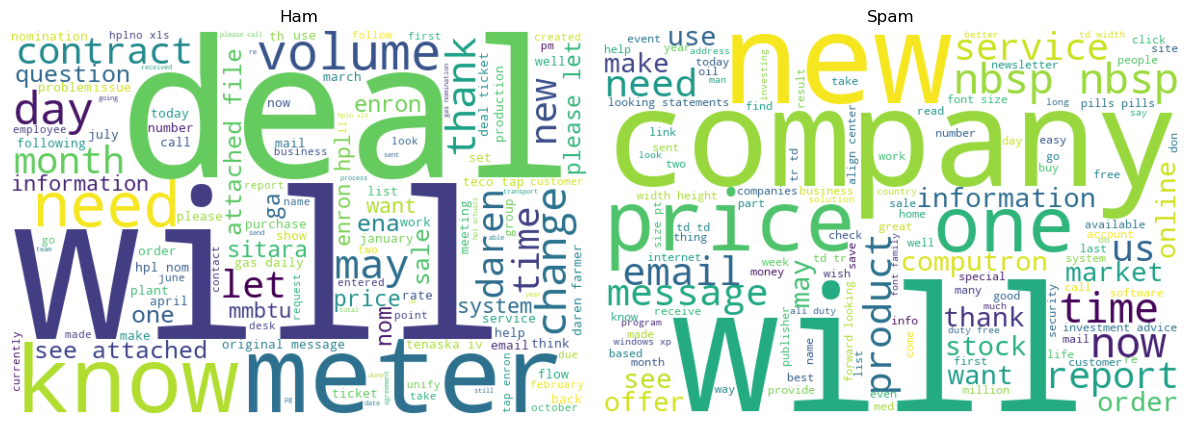

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Wczytywanie danych i usuwanie niepotrzebnego tekstu
dane = pd.read_csv('spam_ham_dataset.csv')
dane['text']=dane['text'].apply(clean_text)

# Oddzielenie spam od ham
ham_emails = [email for email, label in zip(dane['text'],dane['label']) if label == 'ham']
spam_emails = [email for email, label in zip(dane['text'],dane['label']) if label == 'spam']

# Tworzenie chmury wyrazów
n = 10 # liczba słów

# Dla hamu
ham_text = ' '.join(ham_emails)
ham_wordcloud = WordCloud(background_color="white", width=600, height=400, max_words=125).generate(ham_text)

# Dla spamu
spam_text = ' '.join(spam_emails)
spam_wordcloud = WordCloud(background_color="white", width=600, height=400, max_words=125).generate(spam_text)

# Wyświetlanie chmury
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Ham")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam")
plt.axis("off")

plt.tight_layout()
plt.show()

Na powyższych obrazkach widać, że dla Spam i Ham niektóre wyrazy się powtarzają. Na przykład dla obu najczęstrzym wyrazem jest "will" ale inne wyrazy różnią się co do częstotliwości, co można wykorzystać do klasyfikacji e-maili. Dla e-maili typu "spam" widać na przykład, że często powtarza się słowo "company" (zapewne są to maile phishingowe, kierowane do pracowników), albo wiele znaków "nbsp" ("non-breaking space").

Warto zauważyć, że techniki takie jak chmury wyrazów są powszechne w problemach uczenia maszynowego do eksploracji danych tekstowych przed zastosowaniem dowolnego rozwiązania. Proces ten nazywamy `analizą eksploracyjną danych` (EDA). EDA pozwala zrozumieć, w jaki sposób kierować dalszą analizą, a podstawowym narzędziem do tego zadania są metody wizualizacji.

### Statystyki



In [5]:
from scipy.stats import skew
import numpy as np
import pandas as pd

# Oblicz długość każdego e-maila
def statystyki(maile):
    email_lengths = [len(email) for email in maile]
    return [np.mean(email_lengths),
            np.median(email_lengths),
            np.min(email_lengths),
            np.max(email_lengths),
            np.std(email_lengths),
            skew(email_lengths)]

# Przykładowe dane
tabelka = {
'':['Średnia','Mediana','Minimum','Maksimum','Odchylenie standardowe','Skośność'],
'ogólnie':statystyki(dane['text']),
'spam':statystyki(spam_emails),
'ham':statystyki(ham_emails),
}

display(pd.DataFrame(tabelka).style.hide())

,ogólnie,spam,ham
Średnia,841.250822,1200.563042,694.570806
Mediana,444.000000,550.000000,408.000000
Minimum,3.000000,3.000000,10.000000
Maksimum,22064.000000,22064.000000,16143.000000
Odchylenie standardowe,1276.696277,1808.168280,941.510868
Skośność,4.867795,3.597496,5.414015


Skośność to miara asymetrii rozkładu prawdopodobieństwa. 

Wartość skośności może być dodatnia lub ujemna, lub nawet niezdefiniowana:

- Jeśli skośność jest mniejsza od zera, dane są lewostronnie skośne i większość wartości jest większa od średniej.
- Jeśli skośność jest równa zero, dane są symetryczne, chociaż niekoniecznie normalne.
- Jeśli skośność jest większa od zera, dane są prawostronnie skośne.

Wartość skośności wynosi 4.42, co jest dużo większe od zera. To sugeruje, że długości e-maili są prawostronnie skośne, co oznacza, że większość e-maili ma długość mniejszą od średniej, a długie e-maile są rzadkością. W takim przypadku, mediana będzie mniejsza od średniej.

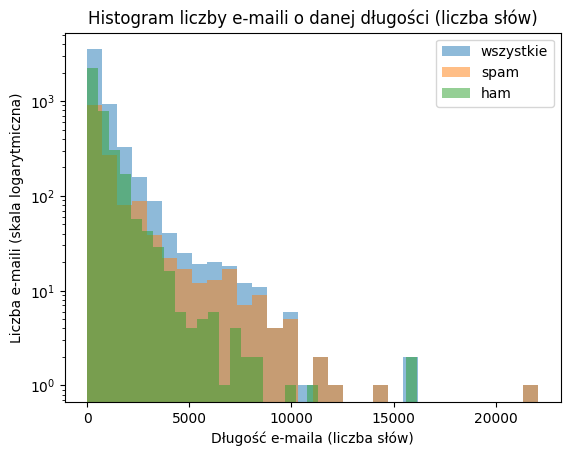

In [8]:
import matplotlib.pyplot as plt

# Histogramy dla każdej serii na tym samym wykresie
plt.hist([len(email) for email in dane['text']], bins=30, alpha=0.5, label='wszystkie', log=True)
plt.hist([len(email) for email in spam_emails], bins=30, alpha=0.5, label='spam', log=True)
plt.hist([len(email) for email in ham_emails], bins=30, alpha=0.5, label='ham', log=True)

plt.title("Histogram liczby e-maili o danej długości (liczba słów)")
plt.xlabel("Długość e-maila (liczba słów)")
plt.ylabel("Liczba e-maili (skala logarytmiczna)")
plt.legend(loc='upper right')
plt.show()

## Braki danych

Jako, że w naszym projekcie potrzbny jest sam email i jego orginalna klasyfikacja to nasz zbiór danych nie zawiera żadnych braków danych

# Przygotowanie danych

W naszej pracy korzystamy z podzbioru zbioru wiadomości e-mail z platformy Kaggle.

Terminem określającym przeciwieństwo wiadomości spamowych jest "ham" (szynka), ponieważ oba słowa są związane z produktami mięsnymi (spam odnosi się do konserwowej szynki, ham do surowej).
Na początku czytamy wiadomości dla obu kategorii (ham i spam) i losowo dzielimy je na grupy treningowe i testowe. Zasadniczo możemy wybrać podział 75:25 między dwoma zestawami, przypisując większą część danym treningowym.

Następnie tokenizujemy te wiadomości, aby podzielić je na oddzielne wyrazy oraz żeby z nich usunąć znaki interpunkcyjne. Usuwamy również tak zwane "stop words" czyli bardzo często występujące słowa w języku angielskim, które wymaga gramatyka tego języka. Są to na przykład słowa: "the", "is", "a", które nie powinny mieć prawie żadnego wpływu na klasyfikacje wiadomości. Potem lematyzujemy słowa czyli przekształcamy słowa na przykład formę liczby mnogiej: "parties" na "party" aby formy danego słowa nie były liczone oddzielnie. Na koniec złączamy słowa spowrotem w całość i uzyskujemy tak wygenerowaną wiadomość.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer

# Załaduj dane.
dane = pd.read_csv('spam_ham_dataset.csv')
dane['text'] = dane['text'].apply(clean_text)

# Podziel dane na zbiory treningowy i testowy.
train_data, test_data, train_class, test_class = train_test_split(dane['text'], dane['label_num'], random_state=123)

# Tokenizuj dane treningowe/testowe. Czyli zmiana całych maili na pojedyńcze słowa
train_data = [word_tokenize(email) for email in train_data]
test_data = [word_tokenize(email) for email in test_data]

# Usunięcie znaków interpunkcyjnych takich jak ":" lub "("
train_data = [[word for word in email if word.isalpha()] for email in train_data]
test_data = [[word for word in email if word.isalpha()] for email in test_data]

# Usunięcie tak zwanych "stop words" czy słowa typu "the", "is", "a"
train_data = [[word for word in email if word not in ENGLISH_STOP_WORDS] for email in train_data]
test_data = [[word for word in email if word not in ENGLISH_STOP_WORDS] for email in test_data]

# Stwórz lematyzer.
lemmatizer = WordNetLemmatizer()

# Lematyzuj tekst.
train_data = [[lemmatizer.lemmatize(word) for word in email] for email in train_data]
test_data = [[lemmatizer.lemmatize(word) for word in email] for email in test_data]

# Odtwórz dane.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

Kontynuujemy ekstrakcją cech dla każdego zdania w obu zestawach. Ten krok wykorzystuje wektorizację tf-idf, po uprzednim wtrenowaniu wektoryzera na danych treningowych.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Stwórz wektorizer.
vectorizer_tfid = TfidfVectorizer()
vectorizer_count = CountVectorizer()

# Dopasuj do danych treningowych.
vectorizer_tfid.fit(train_data)
vectorizer_count.fit(train_data)

# Przekształć dane testowe/treningowe na cechy.
train_data_features_tfid = vectorizer_tfid.transform(train_data)
test_data_features_tfid = vectorizer_tfid.transform(test_data)

train_data_features_count = vectorizer_count.transform(train_data)
test_data_features_count = vectorizer_count.transform(test_data)

print(train_data_features_tfid.shape)

(3878, 35178)


Każda z *3878* wiadomości email w zestawie treningowym jest reprezentowana przez wektor cech o rozmiarze *35178* gdzie każda cechą jest unikatowe słowo w znalezione w email treningowych.

## Wybór metod do klasyfikacji Spamu

Metody używate w naszej pracy zostały wybrane z artykułu "A systematic literature review on spam content detection and classification" napisanego przez Sanaa Kaddoura,Ganesh Chandrasekaran, Daniela Elena Popescu i Jude Hemanth Duraisamy w 2022

> Based on the prior work on spam classification with Machine Learning approaches presented in Table 13, we can conclude that Machine Learning techniques are highly valued by researchers for their importance in spam text classification. Machine learning has the ability to adapt to changing conditions, and it can help overcome the limitations of rule-based spam filtering techniques. Support Vector Machines (SVM), a supervised learning model that analyses data and identifies patterns for classification, is among the most significant machine learning techniques. SVMs are straightforward to train, and some researchers assert that they outperform many popular social media spam classification methods. However, due to the computational complexities of the data input, the resilience and usefulness of SVM for high dimension data shrinks over time. Another machine learning algorithm that has been successfully used to detect spam in social media text is the decision tree. When it comes to training datasets, decision trees (DT) require very little effort from users. They suffer from certain disadvantages, such as the complexity of controlling tree growth without proper pruning and their sensitivity to over fitting of training data. As a consequence, they are rather poor classifiers and their classification accuracy is restricted. A Naive Bayes (NB) classifier simply applies Bayes’ theorem to the perspective classification of each textual data, assuming that the words in the text are unrelated to one another. Because of its simplicity and ease of use, it is ideal for spam classification and it could be used to detect spam messages in a variety of datasets with various features and attributes. An ensemble strategy, which combines various machine learning classifiers, can also be utilized to improve spam categorization jobs. We can deduce from various studies on Machine Learning for spam classification that ML techniques occasionally suffer from computational complexity and domain dependence. The researchers recommend Deep Learning (DL) techniques to avoid such limitations in ML techniques for spam classification because some algorithms take much longer to train and use large resources based on dataset.

## Maszyny wektorów nośnych(SVM)

Jednym z najbardziej znanych algorytmów uczenia maszynowego nadzorowanego jest algorytm `Support Vector Machines` – maszyny wektorów nośnych.

Oceniamy jego wydajność zarówno w zestawie testowym, jak i treningowym. Głównie interesuje nas pierwszy wynik, ponieważ on mierzy dokładność naszego modelu na nieznanych danych; mówiąc inaczej, jak dobrze generalizuje on wiedzę. Z drugiej strony, wyniki na zestawie treningowym wskazują, jak dobrze nasz model nauczył się z danych treningowych. Jak możesz zauważyć, dokładność w tym drugim przypadku nie zawsze wynosi *100%*, czego można by się spodziewać. W praktycznych zastosowaniach prawie zawsze jest znacznie niższa niż *99%*.

Model klasyfikacji SVM (Support Vector Machine) jest jednym z popularnych modeli uczenia maszynowego, który jest wykorzystywany do zadania klasyfikacji danych. Wersja liniowa tego modelu, znana jako SVM liniowe, jest szczególnie prosta i efektywna.

Wzory matematyczne dla modelu SVM liniowego są następujące:

1. Funkcja decyzyjna:
    $$f(x) = sign(w^T * x + b)$$

    gdzie:
    - $x$ to wektor cech wejściowych,
    - $w$ to wektor wag,
    - $b$ to wyraz wolny,
    - $sign()$ to funkcja znaku, która zwraca 1 dla wartości dodatnich i -1 dla wartości ujemnych.

2. Funkcja kosztu:
    $$J(w, b) = C * sum(max(0, 1 - y_i * (w^T * x_i + b))) + 0.5 * ||w||^2$$

    gdzie:
    - $C$ to hiperparametr, który kontroluje kompromis między dopasowaniem do danych treningowych a minimalizacją marginesu,
    - $y_i$ to etykieta klasy dla i-tego przykładu,
    - $x_i$ to i-ty przykład,
    - $||w||$ to norma wektora wag.

Metoda SVM została po raz pierwszy zastosowana w latach 90. XX wieku przez Vladimira Vapnika i jego kolegów. Model SVM liniowy jest stosowany w wielu dziedzinach, takich jak rozpoznawanie obrazów, analiza tekstu, bioinformatyka i wiele innych.

SVM liniowe są atrakcyjne ze względu na swoją prostotę i efektywność obliczeniową. Mają również dobrą zdolność do generalizacji na nowe dane i radzą sobie dobrze w przypadku danych liniowo separowalnych.

W praktyce, do trenowania modelu SVM liniowego, stosuje się różne algorytmy optymalizacyjne, takie jak SMO (Sequential Minimal Optimization) lub GD (Gradient Descent), które minimalizują funkcję kosztu i znajdują optymalne wartości wag i wyrazu wolnego.

In [4]:
from sklearn.decomposition import PCA
from sklearn import svm

# Stwórz PCA transformer.
pca = PCA(n_components=0.95)  # Możesz zmienić liczbę komponentów.

# Dopasuj PCA do danych treningowych.
pca.fit(train_data_features_tfid.toarray())

# Przekształć dane treningowe i testowe.
train_data_pca_tfid = pca.transform(train_data_features_tfid.toarray())
test_data_pca_tfid = pca.transform(test_data_features_tfid.toarray())

train_data_pca_count = pca.transform(train_data_features_count.toarray())
test_data_pca_count = pca.transform(test_data_features_count.toarray())

# Stwórz klasyfikator.
svm_classifier_tfid = svm.SVC(kernel="linear", C=1.0, probability=True)

# Dopasuj klasyfikator do danych treningowych.
svm_classifier_tfid.fit(train_data_pca_tfid, train_class)
svm_classifier=svm_classifier_tfid
# Otrzymaj wynik klasyfikacji danych treningowych.
print(svm_classifier_tfid.score(train_data_pca_tfid, train_class))

0.998968540484786


Teraz wykorzystujemy zestaw testowy.

In [19]:
# Otrzymaj wynik klasyfikacji danych testowych.
svm_tfid = svm_classifier_tfid.score(test_data_pca_tfid, test_class)
svm_count = svm_classifier_tfid.score(test_data_pca_count, test_class)
print("Wynik klasyfikacji z wektoryzacją tfid: ",svm_tfid)
print("Wynik klasyfikacji z wektoryzacją count: ",svm_count)

Wynik klasyfikacji z wektoryzacją tfid:  0.9837587006960556
Wynik klasyfikacji z wektoryzacją count:  0.9675174013921114


## Użycie PCA przed trenowaniem

W początkowym etapie pracy, metoda SVM działała bardzo wolno na naszym zbiorze danych. Aby przyspieszyć nieco obliczenia użyliśmy PCA.

PCA (Principal Component Analysis) jest techniką redukcji wymiarowości, która przekształca dane do nowej przestrzeni o niższej liczbie wymiarów przy zachowaniu jak największej ilości zmienności w danych. Użycie PCA w połączeniu z SVM (Support Vector Machine) w tym kontekście ma kilka kluczowych zalet:

**Redukcja wymiarowości**<br>
Dane tekstowe przetworzone przez TF-IDF (Term Frequency-Inverse Document Frequency) lub metody zliczania cech (Count Vectorizer) mogą prowadzić do bardzo wysokiej wymiarowości. PCA redukuje liczbę wymiarów, zachowując przy tym najistotniejsze informacje. Dzięki temu model SVM działa szybciej i efektywniej.

**Usunięcie szumu**<br>
Wysoka wymiarowość danych często wprowadza szum, który może negatywnie wpływać na wydajność modelu. PCA pomaga w usunięciu mniej istotnych wymiarów, co prowadzi do poprawy wydajności modelu poprzez redukcję szumu.

**Poprawa ogólnej wydajności**<br>
Zredukowana liczba wymiarów sprawia, że model SVM może lepiej generalizować na danych testowych, ponieważ zmniejsza się ryzyko przetrenowania (overfitting). Model staje się bardziej stabilny i mniej podatny na przeuczenie specyficznych cech danych treningowych.

**Złożoność obliczeniowa**<br>
SVM jest algorytmem, którego złożoność obliczeniowa wzrasta wraz z liczbą cech. Redukcja wymiarowości przez PCA zmniejsza czas treningu i predykcji, co jest istotne zwłaszcza przy bardzo dużych zbiorach danych.


## Naïve Bayes

`Naïve Bayes` jest algorytmem klasyfikacji opartym na `twierdzeniu Bayes'a` z założeniem wzajemnej niezależności cech. Nazywany jest 'naiwny' ponieważ w rzeczywistości nie da się zagwarantować pełną niezależność cech, w tym przypadku jedno słowo może wpłynąć na pojawienie się drugiego słowa na przykład przy "machine" może pojawić się "learning". Natomiast pomimo ich naiwnego projektowania i bardzo uproszczonych założeń, w wielu rzeczywistych sytuacjach naiwne klasyfikatory Bayesa często pracują dużo lepiej, niż można było tego oczekiwać. 

### Twierdzenie Bayesa

Twierdzenie (wzór) Bayesa w swej podstawowej formie

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$


gdzie: <br>
$A$ i $B$ są zdarzeniami losowymi, <br>
$P(B)>0$ oznacza że prawdopodobieństwo zdarzenia $B$ jest większe od $0$,<br>
$P(A|B)$ oznacza prawdopodobieństwo zajścia zdarzenia $A$, o ile zajdzie zdarzenie $B$,<br>
$P(B|A)$ oznacza prawdopodobieństwo zajścia zdarzenia $B, o ile zajdzie zdarzenie A$.

### Algorytm Naïve Bayes

W naszym przypadku interesuje nas obliczenie prawdopodobieństwa czy dany email jest spam jeżeli użyte było jakieś słowo czyli:

$$
P(Spam|Word)
$$

Jako, że zakładamy że cechy są niezależne to nasze szukane prawdopodobieństwo można zapisać tak:

$$
\overset{n}{\underset{i=1}{\Pi}}P(Spam|Word_{i})=\overset{n}{\underset{i=1}{\Pi}}\frac{P(Word_{i}|Spam)P(Spam)}{P(Word_{i})}
$$
gdzie:<br>
$n$ to liczba unikatowych słów,<br>
$P(Spam)$ to liczba e-maili treningowych typu "spam" podzielona przez liczbę wszystkich e-maili treningowych,<br>
$P(Word)$ to liczba e-maili treningowych zawierających dane słowo podzielona przez liczbę wszystkich e-maili treningowych,<br>
$P(Word|Spam)$ to prawdopodobieństwo pojawienia się danego słowa jeśli dany e-mail jest typu "spam".<br>

Często też przy użyciu tego algorytmu pojawia się problem zerowego prawdopodobieństwa. Na przykład jeśli jedno ze słów pojawia się tylko w emailach typu "ham" to prawdopodobieństwo tego, że dowolny email zawierający to słowo jest typu "spam", wynosi 0% co powoduje że niezależnie od innych słów email byłby zawsze klasyfikowany jako "ham". Aby tego uniknąć często stosuje się techniki takie jak wygładzenie Laplaca, które sprawia, że liczebność słów w danym email będzie się zaczynała od na przykład 1 zamiast od 0. W kodzie poniżej parametr w klasyfikatorze Naïve Bayesa alpha=1.0 oznacza właśnie że używane jest wygładzenie Laplaca o wysokości 1.

### Wzór wielomianowego Naïve Bayes

W naszym przypadku był użyty wariant wielomianowy Naïve Bayes w celu uwzględnienia liczby wyrazów występujących w danym e-mailu, którego wzór wygląda tak:

$$
\frac{m!\overset{n}{\underset{i=1}{\Pi}}P(Spam|Word_{i})}{\overset{n}{\underset{i=1}{\Pi}}m_{i}!}
$$

gdzie:<br>
$m$ to liczba wszystkich słów,<br>
$m_i$ to liczba wystąpień danego słowa.

In [6]:
from sklearn import naive_bayes

# Stwórz klasyfikator.
nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

# Dopasuj klasyfikator do danych treningowych.
nb_classifier.fit(train_data_features_tfid.toarray(), train_class)

# Pobierz wynik klasyfikacji danych treningowych.
print("Wynik klasyfikacji dla danych treningowych tfid: ", nb_classifier.score(train_data_features_tfid.toarray(), train_class))
print("Wynik klasyfikacji dla danych treningowych count: ", nb_classifier.score(train_data_features_count.toarray(), train_class))

Wynik klasyfikacji dla danych treningowych tfid:  0.9626095925734915
Wynik klasyfikacji dla danych treningowych count:  0.9672511603919546


Następnie sprawdzamy trafność naszej metody dla zestawu e-maili testowych.

In [20]:
# Pobierz wynik klasyfikacji danych testowych.
nb_tfid = nb_classifier.score(test_data_features_tfid.toarray(), test_class)
nb_count = nb_classifier.score(test_data_features_count.toarray(), test_class)
print("Wynik klasyfikacji z wektoryzacją tfid: ",nb_tfid)
print("Wynik klasyfikacji z wektoryzacją count: ",nb_count)

Wynik klasyfikacji z wektoryzacją tfid:  0.9249806651198763
Wynik klasyfikacji z wektoryzacją count:  0.945862335653519


### Podsumowanie

Wyniki sugerują, że trafność klasyfikatora opartego na metodzie Naive Bayser jest niższa od SVM (SVM 98%, a Naive Bayes 92%). Algorytm jest za to o wiele szybszy i bardziej wydajny. Obliczenie wyniku Naive Bayes zajeło 0.2s, a SVM 19.4s. Naive Bayes był zatem 97 razy szybszy.

## Random forest
Metoda lasu losowego wykorzystuje zalety uczenia zespołowego poprzez budowanie wielu drzew decyzyjnych na losowo wybranych próbkach danych. Każde drzewo decyzyjne generuje własną predykcję, a metoda odpowiada za wybór najlepszego wyniku poprzez głosowanie. 

Jak sama nazwa wskazuje, dane są reprezentowane w hierarchii drzewa, gdzie każdy wewnętrzny węzeł (niebędący liściem) jest oznaczony cechą wejściową. Dodatkowo, łuki w węzłach wewnętrznych oznaczają możliwe wartości dla konkretnej cechy. Wreszcie, każdy liść reprezentuje klasę.

Utworzony model może być użyty do wizualnego i jawnego przedstawienia decyzji. Przykład używany przez bank do określania zdolności kredytowej:
![alt text](pliki/z1.png "opcjonalny tytuł")
Przewidywanie zaczyna się od pierwszego węzła (korzenia) i po sprawdzeniu wartości na łukach, kierujemy się odpowiadającą gałęzią do następnego węzła.

Nie istnieje uniwersalna technika kontrakcji drzewa decyzyjnego. Na przestrzeni lat w literaturze zaproponowano wiele różnych metod. Tutaj przyjrzymy się jednej z nich, nazywanej Iterative Dichotomiser 3 (ID3). Metoda ta wykorzystuje dwie znane miary: entropię i zysk informacji. Entropia jest miarą niepewności lub nieuporządkowania. Im bardziej pewne lub deterministyczne jest zdarzenie, tym mniej ma entropii. Entropia jest definiowana następująco:

$$E(S)=\sum_{i=1}^{c} - p_i\log_2(p_i)$$

gdzie:
S = oznacza cały zestaw danych, dla którego obliczana jest entropia.

C = zbiór klas w S.

$p_i$ = oznacza udział procentowy klasy i w stosunku do liczby elementów w zbiorze S.

> **Ciekawostka:** Entropię spotykamy w wielu dziedzinach nauki. Odnosi się ona do idei, że wszystko we wszechświecie ostatecznie przechodzi od uporządkowania do nieuporządkowania, a entropia właśnie mierzy tę zmianę.

### Jak entropia pomaga w budowaniu drzewa decyzyjnego?

Odpowiedź brzmi: zaczynamy od węzła głównego i budujemy drzewo krok po kroku. Wracając więc do rysunku 3.16, decydujemy się umieścić atrybut "Wiek" po atrybucie "Historia kredytowa", ponieważ taki wybór bardziej zmniejsza niepewność (entropię) niż wszystkie inne kandydowane cechy. W ten sam sposób wykonujemy wiele iteracji, aby umieścić wszystkie atrybuty w odpowiednim miejscu drzewa decyzyjnego.

Rolą miernika informacji wzajemnej jest ilościowe określenie zmniejszenia niepewności po podziale zbioru S na podstawie atrybutu A. Dokładniej, oblicza się różnicę między entropią przed podziałem a średnią entropią po podziale. Wskaźnik ten jest definiowany następująco:

miernika informacji wzajemnej(S,A)=$E(S)-\sum_{t=1}^{v} p_t \cdot E_t$

gdzie:
v = liczba wartości atrybutu A.

$p_t$ = udział procentowy liczby elementów w podzbiorze t do liczby elementów w zbiorze S.

$E_t$= entropia podzbioru t.

### Ale w jaki sposób można się upewnić, że te drzewa są różne?

Jeśli dostarczymy algorytmowi te same dane treningowe, logiczne jest myślenie, że w każdej iteracji powstanie ten sam model. Rozwiązaniem w tym przypadku jest umożliwienie każdemu drzewu losowego losowego pobierania próbek z zestawu danych z zastępowaniem. Dzięki losowaniu z zastępowaniem, każda losowo wybrana próbka jest ponownie umieszczana w puli próbek i teoretycznie może zostać wybrana wielokrotnie. Różnica w próbkach daje różne drzewa, proces ten znany jest jako bagging. Inna technika pozwala każdemu drzewu wybierać tylko z losowego podzbioru cech zamiast używać wszystkich. W obu przypadkach wynik daje mniejszą korelację między drzewami i większą różnorodność.

In [8]:
from sklearn.ensemble import RandomForestClassifier
# Stwórz klasyfikator.
randomForestClassifier = RandomForestClassifier()

# Dopasuj klasyfikator do danych treningowych.
randomForestClassifier.fit(train_data_features_tfid.toarray(), train_class)

# Pobierz wynik klasyfikacji danych treningowych.
print("Wynik klasyfikacji danych treningowych: ", randomForestClassifier.score(train_data_features_tfid.toarray(), train_class))

Wynik klasyfikacji danych treningowych:  1.0


In [21]:
# Pobierz wynik klasyfikacji danych testowych.
rf_tfid = randomForestClassifier.score(test_data_features_tfid.toarray(), test_class)
rf_count = randomForestClassifier.score(test_data_features_count.toarray(), test_class)
print("Wynik klasyfikacji z wektoryzacją tfid: ",rf_tfid)
print("Wynik klasyfikacji z wektoryzacją count: ",rf_count)

Wynik klasyfikacji z wektoryzacją tfid:  0.9752513534416086
Wynik klasyfikacji z wektoryzacją count:  0.974477958236659


## Model hybrydowy
Model hybrydowy klasyfikacji, który został opisany w kodzie, wykorzystuje trzy różne modele klasyfikacji: Naive Bayes, Random Forest i SVM. Każdy z tych modeli generuje predykcje dla danych testowych.

Najpierw, dla każdego z modeli, obliczane są prawdopodobieństwa przynależności do poszczególnych klas dla danych testowych.

Następnie, ostateczna predykcja jest obliczana jako średnia z predykcji trzech modeli. Dla każdego przykładu testowego, obliczane jest średnie prawdopodobieństwo przynależności do każdej klasy na podstawie predykcji trzech modeli.

Na koniec, ostateczna predykcja jest określana jako klasa o najwyższym średnim prawdopodobieństwie. Wybierana jest klasa, dla której średnie prawdopodobieństwo jest największe.

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
class HybridModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, model3, pca):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.pca = pca

    def fit(self, X, y):
        self.pca = PCA(n_components=0.95)
        self.pca.fit(X)
        X_pca = self.pca.transform(X)
        self.model1.fit(X, y)
        self.model2.fit(X, y)
        self.model3.fit(X_pca, y)
        return self

    def predict(self, X):
        final_pred = self.predict_proba(X)
        return np.argmax(final_pred, axis=1)

    def predict_proba(self, X):
        pred1 = self.model1.predict_proba(X)
        pred2 = self.model2.predict_proba(X)
        pred3 = self.model3.predict_proba(self.pca.transform(X))
        return (pred1 + pred2 + pred3) / 3
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
hybrydowy_Classifier=HybridModel(nb_classifier,randomForestClassifier,svm_classifier,pca)
Hybrydowy_final_pred=hybrydowy_Classifier.predict(test_data_features_tfid)
# Oblicz dokładność hybrydowego modelu.
hybrydowwy_accuracy_tfid=accuracy_score(test_class, Hybrydowy_final_pred)
print("Skuteczność modelu hybrydowego z wektoryzacją tfid: ", hybrydowwy_accuracy_tfid)
Hybrydowy_final_pred2=hybrydowy_Classifier.predict(test_data_features_count)
# Oblicz dokładność hybrydowego modelu.
hybrydowwy_accuracy_count=accuracy_score(test_class, Hybrydowy_final_pred2)
print("Skuteczność modelu hybrydowego z wektoryzacją count: ", hybrydowwy_accuracy_count)


Skuteczność modelu hybrydowego z wektoryzacją tfid:  0.9876256767208044
Skuteczność modelu hybrydowego z wektoryzacją count:  0.9690641918020109


## Porównanie metod wektoryzacji

In [18]:
wyniki = {
'':['SVM','Naive Bayes','Random Forest','Hybrydowy'],
'tfid':[svm_tfid,nb_tfid,rf_tfid,hybrydowwy_accuracy_tfid],
'count':[svm_count,nb_count,rf_count,hybrydowwy_accuracy_count],
}

display(pd.DataFrame(wyniki).style.hide())

,tfid,count
SVM,0.983759,0.967517
Naive Bayes,0.924981,0.945862
Random Forest,0.975251,0.974478
Hybrydowy,0.987626,0.969064


Jak widać wybranie metody wektoryzacji wpływa na efektywność metod klasyfikacji w przypadku metody SVM i hybrydowej lepszy wynik osiągneła metoda tfid, w przypadku naive Bayes count, a w przypadku Random forest wybrane metody wektoryzacji nie mają dużego wpływu.

## Dokładność

Standardowym podejściem w każdym problemie uczenia maszynowego jest wykorzystanie różnych algorytmów klasyfikacji i sprawdzenie, który z nich działa najlepiej. Wcześniej zastosowaliśmy dwie metody klasyfikacji do problemu filtrowania spamu, ale nasza praca się jeszcze nie skończyła; musimy dokładniej ocenić ich wydajność.

`Dokładność` to procent prawidłowo sklasyfikowanych przykładów przez algorytm, dzielony przez całkowitą liczbę przykładów.
$$
\text{Dokładność} = \frac{\text{Liczba poprawnie sklasyfikowanych przykładów}}{\text{Łączna liczba przykładów}}
$$
 Poniższy kod oblicza dokładność na tych samych danych; jego wartość jest identyczna z wartością z poprzedniej sekcji.

In [15]:
from sklearn import metrics
import pandas as pd
svm_test_class_pred = svm_classifier_tfid.predict(test_data_pca_tfid)
randomForestClassifier_test_class_pred = randomForestClassifier.predict(test_data_features_tfid.toarray())
nb_classifier_test_class_pred = nb_classifier.predict(test_data_features_tfid.toarray())
hybrydowy_Classifier_test_class_pred=hybrydowy_Classifier.predict(test_data_features_tfid.toarray())
def dokladnosc(test_class_pred):
    # Oblicz dokładność na zbiorze testowym.
    return metrics.accuracy_score(test_class, test_class_pred)

# Utwórz słownik z danymi
data = {
    'model': ['svm_classifier', 'randomForestClassifier', 'nb_classifier','model_hybrydowy'],
    'dokładność': [dokladnosc(svm_test_class_pred),
                   dokladnosc(randomForestClassifier_test_class_pred),
                     dokladnosc(nb_classifier_test_class_pred),
                     dokladnosc(hybrydowy_Classifier_test_class_pred)]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(df)

,model,dokładność
0,svm_classifier,0.983759
1,randomForestClassifier,0.977572
2,nb_classifier,0.924981
3,model_hybrydowy,0.986079


# Interpretacja tabeli dokładnośći

1. **Model hybrydowy wykazał się najwyższą dokładnością**, co sugeruje, że łączenie różnych technik klasyfikacyjnych może przynieść korzyści w postaci poprawy wydajności. Takie podejście może pozwolić na wykorzystanie różnorodnych właściwości poszczególnych modeli, co prowadzi do bardziej wszechstronnych i dokładniejszych predykcji.

2. **SVM osiągnął wysoką dokładność, co wskazuje na jego stabilność i skuteczność w różnych zadaniach klasyfikacyjnych**. Model ten wykorzystuje hiperpłaszczyzny w wielowymiarowej przestrzeni cech do skutecznego separowania klas, co przekłada się na wysoką skuteczność predykcji.

3. **Random Forest również osiągnął wysoką dokładność, choć nieco niższą niż SVM i model hybrydowy**. Jednakże, jego zdolność do agregacji wyników wielu drzew decyzyjnych nadal czyni go solidnym wyborem dla wielu zadań klasyfikacyjnych.

4. **Naive Bayes uzyskał najniższą dokładność**. Jest to prawdopodobnie spowodowane jego prostotą i założeniem o niezależności zmiennych, które mogą być niespełnione w rzeczywistych danych. Niemniej jednak, Naive Bayes nadal może być użyteczny w przypadkach, gdy inne modele mają trudności z działaniem na dużych zbiorach danych lub wymagają większej mocy obliczeniowej.


## Precision i Recall

`Precyzja` mówi nam o proporcji pozytywnych identyfikacji, które w rzeczywistości są poprawne, natomiast `Pełność` mówi nam o proporcji faktycznych elementów pozytywnych, które zostały prawidłowo zidentyfikowane.
$$
\text{Precyzja} = \frac{\text{TP}}{\text{TP}+\text{FP}}
$$

$$
\text{Pełność} = \frac{\text{TP}}{\text{TP}+\text{FN}}
$$

In [16]:
# Utwórz słownik z danymi
data = {
    'model': ['svm_classifier', 'randomForestClassifier', 'nb_classifier','model_hybrydowy'],
    'Precision': [metrics.precision_score(test_class, svm_test_class_pred),
                   metrics.precision_score(test_class, randomForestClassifier_test_class_pred),
                   metrics.precision_score(test_class, nb_classifier_test_class_pred),
                   metrics.precision_score(test_class, hybrydowy_Classifier_test_class_pred)],
    'Recall': [metrics.recall_score(test_class, svm_test_class_pred),
                   metrics.recall_score(test_class, randomForestClassifier_test_class_pred),
                   metrics.recall_score(test_class, nb_classifier_test_class_pred),
                   metrics.recall_score(test_class, hybrydowy_Classifier_test_class_pred)]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(df)



,model,Precision,Recall
0,svm_classifier,0.960227,0.979710
1,randomForestClassifier,0.938889,0.979710
2,nb_classifier,0.992063,0.724638
3,model_hybrydowy,0.979472,0.968116


## Analiza tabeli Precision i Recall

Analiza precyzji (Precision) i czułości (Recall) dla różnych modeli klasyfikacyjnych pozwala na głębsze zrozumienie ich skuteczności i potencjalnych zastosowań.

**svm_classifier**:
- Model SVM charakteryzuje się wysoką precyzją i czułością. Wysoka precyzja oznacza, że spośród wszystkich przypadków sklasyfikowanych jako pozytywne, 96.02% rzeczywiście jest pozytywnych, co wskazuje na niską liczbę fałszywych alarmów. Wysoka czułość (97.97%) sugeruje, że model skutecznie identyfikuje większość rzeczywistych pozytywnych przypadków, minimalizując przeoczenia. Taka kombinacja czyni SVM odpowiednim do zastosowań, gdzie zarówno fałszywe alarmy, jak i przeoczenia muszą być minimalizowane.

**dt_classifier**:
- Model Decision Tree ma nieco niższą precyzję (93.89%) w porównaniu do SVM, co sugeruje, że częściej klasyfikuje negatywne przypadki jako pozytywne, prowadząc do większej liczby fałszywych alarmów. Jednakże, utrzymuje wysoką czułość (97.97%), co wskazuje na podobną skuteczność w wykrywaniu pozytywnych przypadków. Taka charakterystyka jest korzystna w sytuacjach, gdzie wykrycie wszystkich pozytywnych przypadków jest krytyczne, nawet kosztem większej liczby fałszywych alarmów.

**nb_classifier**:
- Model Naive Bayes wyróżnia się bardzo wysoką precyzją (99.21%), co oznacza, że prawie wszystkie sklasyfikowane pozytywne przypadki są rzeczywiście pozytywne, wskazując na minimalną liczbę fałszywych alarmów. Jednakże, niska czułość (72.46%) wskazuje, że model ma trudności z wykrywaniem wszystkich rzeczywistych pozytywnych przypadków, co prowadzi do wielu przeoczeń. Może to wynikać z założenia Naive Bayesa o niezależności cech, które rzadko jest spełnione w rzeczywistych danych. Model ten jest odpowiedni tam, gdzie fałszywe alarmy muszą być minimalizowane, a przeoczenie niektórych pozytywnych przypadków jest akceptowalne.

**model_hybrydowy**:
- Model hybrydowy, łącząc różne techniki klasyfikacyjne, osiąga wysoką precyzję (97.95%) i czułość (96.81%). Taka kombinacja sugeruje, że model skutecznie równoważy liczbę fałszywych alarmów i przeoczeń. Wysoka precyzja wskazuje na niską liczbę fałszywych alarmów, a wysoka czułość świadczy o zdolności do wykrywania większości rzeczywistych pozytywnych przypadków. Hybrydowe podejście pozwala na lepsze wykorzystanie zalet różnych metod klasyfikacyjnych, prowadząc do bardziej wszechstronnego i niezawodnego modelu. Model ten jest szczególnie użyteczny w aplikacjach wymagających równocześnie niskiej liczby fałszywych alarmów i wysokiej czułości.

Podsumowując, model hybrydowy wyróżnia się najbardziej zrównoważonymi wynikami precyzji i czułości, podczas gdy SVM i Random Forest również oferują wysoką skuteczność z pewnymi różnicami w liczbie fałszywych alarmów. Naive Bayes, mimo bardzo wysokiej precyzji, ma ograniczoną czułość, co czyni go mniej odpowiednim do sytuacji wymagających wykrycia jak największej liczby pozytywnych przypadków.


## F-score
`F-score`, to miara skuteczności modelu klasyfikacyjnego, jest średnią harmoniczną precyzji i odwołania, co oznacza, że F-score uwzględnia zarówno fałszywe alarmy (false positives), jak i przeoczenia (false negatives). F-score jest szczególnie użyteczny, gdy istnieje nierównowaga klas w danych, czyli gdy jedna klasa jest znacznie liczniejsza niż druga. Kiedy precyzja i odwołanie osiągają idealny wynik (równy *1*), F-score staje się równe *1*.
$$
\text{F-score} = 2 \cdot \frac{\text{precyzja} \cdot \text{odwołanie}}{\text{precyzja}+\text{odwołanie}}
$$

In [17]:
# Utwórz słownik z danymi
data = {
    'model': ['svm_classifier', 'randomForestClassifier', 'nb_classifier','model_hybrydowy'],
    'F-score': [metrics.f1_score(test_class, svm_test_class_pred),
                   metrics.f1_score(test_class, randomForestClassifier_test_class_pred),
                   metrics.f1_score(test_class, nb_classifier_test_class_pred),
                   metrics.f1_score(test_class, hybrydowy_Classifier_test_class_pred)]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(df)


,model,F-score
0,svm_classifier,0.969871
1,randomForestClassifier,0.958865
2,nb_classifier,0.837521
3,model_hybrydowy,0.973761


# Interpretacja wyników tabeli F-score

**svm_classifier**:
- Model SVM (Support Vector Machine) osiągnął bardzo wysoki F-score, co wskazuje na doskonałą równowagę między precyzją a czułością. SVM jest znany ze swojej skuteczności w klasyfikacji złożonych i wielowymiarowych danych. Wysoki F-score sugeruje, że model ten skutecznie minimalizuje zarówno fałszywe alarmy (false positives), jak i przeoczenia (false negatives).

**dt_classifier**:
- Model Decision Tree również osiągnął wysoki F-score, choć nieco niższy niż SVM. Random Forest, jako zespół drzew decyzyjnych, korzysta z agregacji wyników wielu drzew, co zwiększa stabilność i dokładność predykcji. Nieco niższy F-score w porównaniu do SVM może wynikać z większej liczby fałszywych alarmów (false positives).

**nb_classifier**:
- Model Naive Bayes osiągnął najniższy F-score w tej analizie. Naive Bayes jest prostym modelem probabilistycznym, który często nie radzi sobie dobrze z bardziej złożonymi zależnościami w danych. Niski F-score sugeruje, że model ten może mieć problemy z precyzją i czułością w kontekście bardziej skomplikowanych zbiorów danych.

**model_hybrydowy**:
- Model hybrydowy osiągnął najwyższy F-score, co sugeruje, że łączenie różnych technik klasyfikacyjnych może prowadzić do lepszej wydajności niż stosowanie pojedynczych modeli. Wysoki F-score wskazuje na doskonałą równowagę między precyzją a czułością, co czyni go najbardziej efektywnym spośród analizowanych modeli.

### Wnioski:

1. **Model hybrydowy** wykazuje najwyższą skuteczność, co sugeruje, że integracja różnych metod klasyfikacyjnych może poprawić wydajność.
2. **SVM** i **Decision Tree** również osiągają wysokie F-score, wskazując na ich przydatność w złożonych zadaniach klasyfikacyjnych.
3. **Naive Bayes** wypada najsłabiej, co może wynikać z jego prostoty i ograniczonej zdolności do modelowania skomplikowanych zależności w danych.

## ROC i AUC

Kiedy klasyfikator zwraca dla każdej predykcji pewnego rodzaju wynik ufności, możemy zastosować inną technikę oceny wydajności, nazywaną krzywą `charakterystyki operacyjnej odbiornika` (ROC). Krzywa ROC jest wykresem graficznym, który pokazuje wydajność modelu przy wszystkich progach klasyfikacji. Zacieniony obszar na tych wykresach, nazywany `polem pod krzywą ROC` (AUC), jest związany z jakością naszego modelu; im większa jego powierzchnia, tym lepiej.
> **Ciekawostka:** Inżynierowie radarów po raz pierwszy opracowali krzywą ROC podczas II wojny światowej w celu wykrywania obiektów wroga na polach bitew.

Podsumowując, korzyści z używania krzywych ROC są dwojakie:
1. Możemy bezpośrednio porównywać różne modele, aby znaleźć ten z wyższą wartością AUC.
2. Możemy określić, która kombinacja TPR i FPR oferuje dobrą wydajność klasyfikacji dla konkretnego modelu.

Następnie obliczymy krzywe ROC dla obu klasyfikatorów.

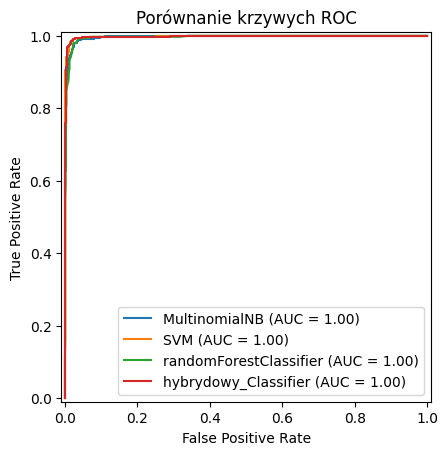

In [18]:
from matplotlib import pyplot as plt

# Stwórz pojedynczą figurę i oś dla wykresu ROC.
fig, ax = plt.subplots()

def wykres(zbior,model,nazwa):
    # Uzyskaj wyniki dla każdej predykcji.
    probs = model.predict_proba(zbior)
    test_score = probs[:, 1]

    # Oblicz charakterystykę pracy odbiornika.
    fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

    # Utwórz pojedynczą figurę i oś dla wykresu ROC.
    roc_auc = metrics.auc(fpr, tpr)

    # Stwórz krzywą ROC.
    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=nazwa).plot(ax=ax)

wykres(test_data_features_tfid.toarray(),nb_classifier,'MultinomialNB')
wykres(test_data_pca_tfid,svm_classifier_tfid,'SVM')
wykres(test_data_features_tfid.toarray(),randomForestClassifier,'randomForestClassifier')
wykres(test_data_features_tfid.toarray(),hybrydowy_Classifier,'hybrydowy_Classifier')



# Ustaw tytuł wykresu.
ax.set_title("Porównanie krzywych ROC")

plt.show()

## Interpretacja wykresu

Wykres ROC przedstawia porównanie skuteczności czterech klasyfikatorów: MultinomialNB, SVM, RandomForestClassifier oraz hybrydowego klasyfikatora. Wszystkie osiągnęły doskonałe wyniki z AUC równym 1.0, co wskazuje na ich idealną zdolność do rozróżniania klas. Niemniej jednak, szczegółowa analiza zakresu 0.0-0.2 False Positive Rate (FPR) pozwala dostrzec subtelne różnice w ich działaniu.

### MultinomialNB 
- **Multinomial Naive Bayes** osiąga szybko wysoki True Positive Rate (TPR) nawet przy bardzo niskim FPR. Oznacza to, że model skutecznie identyfikuje większość pozytywnych przykładów bez dużego błędu fałszywie pozytywnych. Jest to charakterystyczne dla danych, gdzie założenie niezależności cech jest dobrze spełnione.

### SVM 
- **Support Vector Machine** pokazuje bardzo strome nachylenie na początku zakresu FPR, co oznacza, że szybko osiąga wysoki TPR przy minimalnym wzroście FPR. SVM jest znany ze swojej zdolności do znalezienia optymalnej granicy decyzji w przypadku dobrze separowalnych danych.

### RandomForestClassifier
- **Random Forest Classifier** wykazuje strome nachylenie, ale może być nieco mniej strome w porównaniu do SVM w najniższym zakresie FPR. Dzięki wielokrotnemu próbkowaniu i tworzeniu wielu drzew decyzyjnych, model ten uchwyci bardziej złożone zależności w danych, co może prowadzić do większej zmienności przy bardzo niskim FPR.

### Hybrydowy_Classifier
- **Hybrydowy klasyfikator** łączy zalety różnych podejść, co skutkuje bardzo podobnym zachowaniem do SVM i Random Forest w zakresie 0.0-0.2 FPR. Wykorzystanie mocnych stron obu modeli prowadzi do bardzo dobrych wyników przy niskim FPR.

### Podsumowanie
Subtelne różnice w zakresie 0.0-0.2 False Positive Rate wskazują, że:
- **SVM** i **Hybrydowy klasyfikator** mają bardzo szybki wzrost TPR przy minimalnym FPR, co czyni je efektywnymi w wykrywaniu pozytywnych przypadków przy minimalnym błędzie na początku.
- **MultinomialNB** również osiąga wysoki TPR przy niskim FPR, ale może być nieco mniej skuteczny niż SVM i hybrydowy model w najniższym zakresie FPR.
- **Random Forest** jest bardzo skuteczny, ale może wykazywać nieco większą zmienność w bardzo niskim zakresie FPR, co może wynikać z jego natury jako modelu zespołowego.

Zgodnie z rysunkiem, wartość AUC dla SVM wynosi *1*, a dla Naive Bayes *1*. Wszystkie dotychczasowe wyniki potwierdzają nasze początkowe założenie o wyższości modelu SVM.

Na koniec obliczymy krzywą ROC wraz z `krzywą Precyzj Odwołania` dla modelu Naive Bayes.

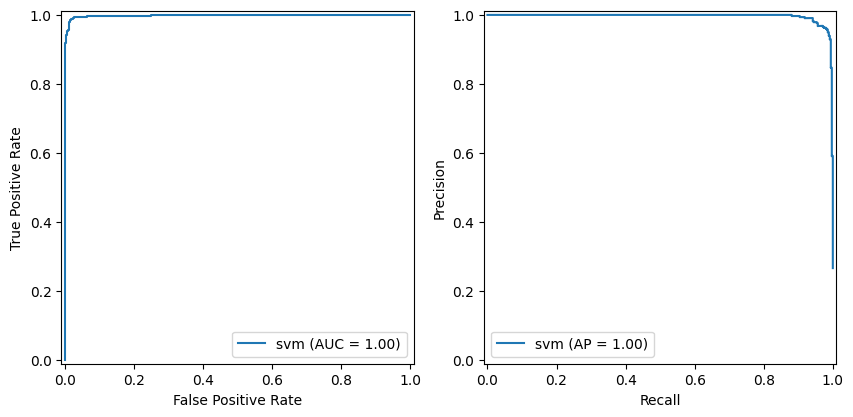

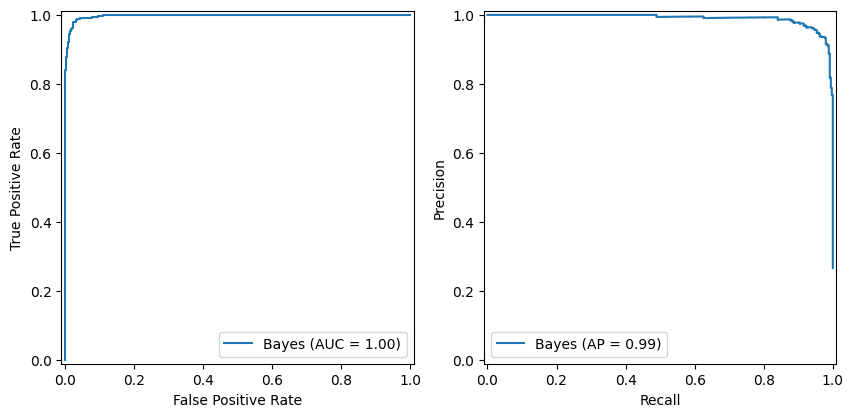

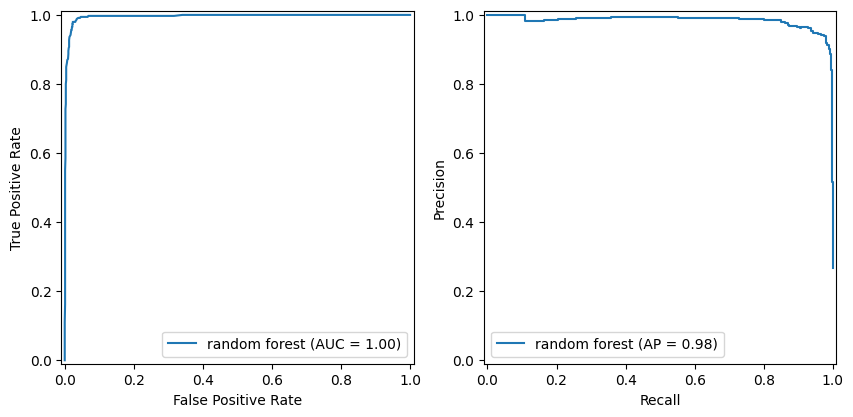

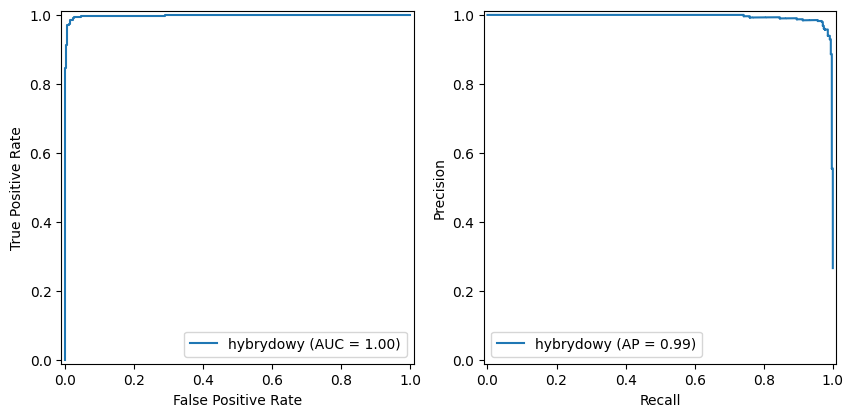

In [19]:
def rocdraw(dane,model,nazwa):
    # Uzyskaj wyniki dla każdej predykcji.
    probs = model.predict_proba(dane)
    test_score = probs[:, 1]

    # Oblicz charakterystykę pracy odbiornika.
    fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

    # Oblicz pole powierzchni pod krzywą.
    roc_auc = metrics.auc(fpr, tpr)

    # Stwórz krzywą ROC.
    rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=nazwa)

    # Stwórz krzywe precyzja-odzyskiwanie.
    precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
    ap = metrics.average_precision_score(test_class, test_score)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name=nazwa)

    # Narysuj krzywe.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    rc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
rocdraw(test_data_pca_tfid,svm_classifier_tfid,"svm")
rocdraw(test_data_features_tfid.toarray(),nb_classifier,"Bayes")
rocdraw(test_data_features_tfid.toarray(),randomForestClassifier,"random forest")
rocdraw(test_data_features_tfid.toarray(),hybrydowy_Classifier,"hybrydowy")

Oba wykresy podsumowują zależności między wskaźnikami na osi X i Y, wykorzystując różne progi prawdopodobieństwa. Na prawym wykresie średnia precyzja (AP) dla modelu Naive Bayes wynosi *0,99*.

## Walidacja krzyżowa
Walidacja krzyżowa (cross-validation) jest techniką używaną do oceny wydajności modelu uczenia maszynowego. Polega na podziale dostępnych danych na zbiór treningowy i zbiór testowy, a następnie wielokrotnym powtórzeniu tego procesu, zmieniając podział danych. 

Wzór matematyczny dla walidacji krzyżowej można przedstawić następująco:

1. Podziel zbiór danych na k równych części (np. k-fold cross-validation) lub na k części o podobnej proporcji klas (np. stratified k-fold cross-validation).
2. Dla każdego podziału:

   a. Wybierz jedną część jako zbiór testowy, a pozostałe części jako zbiór treningowy.

   b. Wytrenuj model na zbiorze treningowym.

   c. Oceń wydajność modelu na zbiorze testowym.

   d. Zapisz wynik oceny wydajności.
   
3. Oblicz średnią i odchylenie standardowe wyników oceny wydajności dla wszystkich podziałów.

Pierwsze użycie walidacji krzyżowej w kontekście uczenia maszynowego można przypisać do prac Ronalda A. Fishera w latach 30. XX wieku. Jednakże, konkretna metoda k-krotnej walidacji krzyżowej została wprowadzona przez Davida G. Hinkleya w 1975 roku. Od tego czasu walidacja krzyżowa stała się popularną techniką oceny modeli uczenia maszynowego.

In [20]:
from sklearn.model_selection import cross_val_score

hyb_scores = cross_val_score(hybrydowy_Classifier, train_data_features_tfid.toarray(), train_class, cv=5)
svm_scores = cross_val_score(svm_classifier_tfid, train_data_pca_tfid, train_class, cv=5)
nb_scores = cross_val_score(nb_classifier, train_data_features_tfid.toarray(), train_class, cv=5)
rf_scores = cross_val_score(randomForestClassifier, train_data_features_tfid.toarray(), train_class, cv=5)

data = {
    'model': ['svm_classifier', 'randomForestClassifier', 'nb_classifier','hybrydowy'],
    'wyniki': [svm_scores,rf_scores,nb_scores,hyb_scores],
    'Średnia wyników': [svm_scores.mean(),rf_scores.mean(),nb_scores.mean(),hyb_scores.mean()]
}

df = pd.DataFrame(data)

display(df)

,model,wyniki,Średnia wyników
0,svm_classifier,"[0.9806701030927835, 0.9806701030927835, 0.979...",0.982725
1,randomForestClassifier,"[0.9729381443298969, 0.970360824742268, 0.9806...",0.975503
2,nb_classifier,"[0.8904639175257731, 0.8943298969072165, 0.903...",0.900210
3,hybrydowy,"[0.9858247422680413, 0.9768041237113402, 0.987...",0.985819


### Interpretacja wyników modeli klasyfikacyjnych z walidacji krzyżowej

**svm_classifier**:
- Model SVM (Support Vector Machine) osiągnął bardzo wysoką średnią wyników z walidacji krzyżowej, co wskazuje na jego spójną i wysoką skuteczność w różnych podziałach danych. Wysoka średnia wyników sugeruje, że model ten jest stabilny i dobrze radzi sobie z różnorodnymi zbiorami danych.

**randomForestClassifier**:
- Random Forest osiągnął wysoką średnią wyników, choć nieco niższą niż SVM. Model ten, dzięki agregacji wyników wielu drzew decyzyjnych, jest stabilny i skuteczny. Nieco niższa średnia wyników w porównaniu do SVM może wynikać z większej liczby fałszywych alarmów (false positives) w niektórych podziałach danych.

**nb_classifier**:
- Naive Bayes osiągnął najniższą średnią wyników spośród analizowanych modeli. Naive Bayes jest prostym modelem probabilistycznym, który często nie radzi sobie dobrze z bardziej złożonymi zależnościami w danych. Niska średnia wyników sugeruje, że model ten może mieć problemy z precyzją i czułością w różnych podziałach danych.

**hybrydowy**:
- Model hybrydowy osiągnął najwyższą średnią wyników z walidacji krzyżowej, co sugeruje, że łączenie różnych technik klasyfikacyjnych prowadzi do lepszej wydajności. Wysoka średnia wyników wskazuje na doskonałą równowagę między precyzją a czułością, co czyni go najbardziej efektywnym spośród analizowanych modeli.

### Wnioski:
1. **Model hybrydowy** wykazuje najwyższą skuteczność, co sugeruje, że integracja różnych metod klasyfikacyjnych może poprawić wydajność.
2. **SVM** również osiąga bardzo wysoką średnią wyników, wskazując na jego stabilność i skuteczność w złożonych zadaniach klasyfikacyjnych.
3. **Random Forest** osiąga wysoką średnią wyników, co czyni go solidnym wyborem, choć nieco mniej skutecznym niż SVM i model hybrydowy.
4. **Naive Bayes** wypada najsłabiej, co może wynikać z jego prostoty i ograniczonej zdolności do modelowania skomplikowanych zależności w danych.


## Test modeli na innym zbiorze danych

In [27]:
from myf import test
test_data_features_tfid,test_class_tfid = test(vectorizer_tfid)
test_data_features_count,test_class_count = test(vectorizer_count)

# Utwórz słownik z danymi
data = {
    'model': ['svm_classifier', 'randomForestClassifier', 'nb_classifier','hybrydowy'],
    'dokładność': [svm_classifier_tfid.score(pca.transform(test_data_features_tfid.toarray()), test_class_tfid),
                   randomForestClassifier.score(test_data_features_tfid.toarray(), test_class_tfid),
                  nb_classifier.score(test_data_features_count.toarray(), test_class_count),
                  hybrydowy_Classifier.score(test_data_features_tfid.toarray(), test_class_tfid)
                     ]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(df)

,model,dokładność
0,svm_classifier,0.835400
1,randomForestClassifier,0.826381
2,nb_classifier,0.627959
3,hybrydowy,0.816234


### Interpretacja wyników modeli klasyfikacyjnych na innym zbiorze danych

**svm_classifier**:
- Model SVM (Support Vector Machine) osiągnął najwyższą dokładność spośród analizowanych modeli. Wysoka dokładność sugeruje, że SVM skutecznie klasyfikuje przypadki w nowym zbiorze danych, minimalizując liczbę błędnych klasyfikacji.

**randomForestClassifier**:
- Random Forest osiągnął wysoką dokładność, choć nieco niższą niż SVM. Random Forest, dzięki agregacji wyników wielu drzew decyzyjnych, jest stabilnym i efektywnym modelem. Nieco niższa dokładność w porównaniu do SVM może wynikać z większej liczby błędnych klasyfikacji w niektórych przypadkach.

**nb_classifier**:
- Naive Bayes osiągnął najniższą dokładność, co sugeruje, że model ten nie radzi sobie dobrze z nowym zbiorem danych. Niska dokładność wskazuje na dużą liczbę błędnych klasyfikacji, co może wynikać z prostoty modelu i jego ograniczonej zdolności do modelowania złożonych zależności w danych.

**hybrydowy**:
- Model hybrydowy osiągnął wysoką dokładność, choć niższą niż SVM i Random Forest. Wysoka dokładność modelu hybrydowego wskazuje na jego skuteczność w łączeniu różnych technik klasyfikacyjnych, chociaż w tym przypadku jego wydajność jest nieco niższa niż oczekiwano.

### Wnioski:
1. **SVM** wykazuje najwyższą dokładność na nowym zbiorze danych, co sugeruje jego wysoką skuteczność w klasyfikacji.
2. **Random Forest** również osiąga wysoką dokładność, co czyni go solidnym wyborem, choć nieco mniej skutecznym niż SVM.
3. **Model hybrydowy** osiąga wysoką dokładność, wskazując na skuteczność integracji różnych metod klasyfikacyjnych, chociaż w tym przypadku jego wydajność jest niższa niż SVM i Random Forest.
4. **Naive Bayes** wypada najsłabiej, co może wynikać z jego prostoty i ograniczonej zdolności do modelowania złożonych zależności w danych.


## Demonstracja

In [28]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
# przykładowy spam.
spam = """
Dear Valued Customer,

Congratulations! You have been selected as the winner of an all-expenses-paid vacation to a tropical paradise! This exclusive offer is only available to a select few, and you are one of the lucky recipients!

To claim your prize, simply click on the link below and fill out the required information:

[Claim Your Free Vacation Now!](http://example-spam-link.com)

Hurry, this offer is only valid for the next 24 hours. Don’t miss out on this once-in-a-lifetime opportunity to relax and unwind in a beautiful destination.

Best regards,
The Prize Team

Note: If you do not wish to receive further emails from us, please click [here](http://example-unsubscribe-link.com) to unsubscribe.


"""
spam2= """
Dear MR tjones,	
You have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!
Even if you change your password my virus CANNOT BE intercepted!
The only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9w
You have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!

"""

ham = """
Hi Team,

This is a reminder about our project update meeting scheduled for tomorrow at 10:00 AM in the main conference room. We will be discussing the progress of our current tasks and planning the next steps. 

Please make sure to bring any relevant documents and updates from your respective departments.

Looking forward to a productive meeting.

Best regards,
Jane Doe
Project Manager
Company Inc.
"""

def przetworz(email, vectorizer):
    # Tokenizuj dane. Czyli zmiana całego maila na pojedyńcze słowa
    email_data = word_tokenize(email)

    # Usunięcie znaków interpunkcyjnych takich jak ":" lub "("
    email_data = [word for word in email_data if word.isalpha()]

    # Usunięcie tak zwanych "stop words" czy słowa typu "the", "is", "a"
    email_data = [word for word in email_data if word not in ENGLISH_STOP_WORDS]

    # Stwórz lematyzer.
    lemmatizer = WordNetLemmatizer()

    # Lematyzuj tekst.
    email_data = [lemmatizer.lemmatize(word) for word in email_data]

    # Odtwórz dane.
    email_data = " ".join(email_data)
    return vectorizer.transform([email_data])
def kategoria(tab):
    if tab[0]==0:
        return "ham"
    return "spam"
# Utwórz słownik z danymi
data = {
    'model': ['svm_classifier','randomForestClassifier','nb_classifier','hybrydowy'],
    'ham': [
        kategoria(svm_classifier.predict(pca.transform(przetworz(ham, vectorizer_tfid)))),
        kategoria(randomForestClassifier.predict(przetworz(ham, vectorizer_tfid))),
        kategoria(nb_classifier.predict(przetworz(ham, vectorizer_count))),
        kategoria(hybrydowy_Classifier.predict(przetworz(ham, vectorizer_tfid)))
    ],
    'ham prawdopodobienstwo': [
        svm_classifier.predict_proba(pca.transform(przetworz(ham, vectorizer_tfid)))[0][0],
        randomForestClassifier.predict_proba(przetworz(ham, vectorizer_tfid))[0][0],
        nb_classifier.predict_proba(przetworz(ham, vectorizer_count))[0][0],
        hybrydowy_Classifier.predict_proba(przetworz(ham, vectorizer_tfid))[0][0]
    ],
    'spam': [
        kategoria(svm_classifier.predict(pca.transform(przetworz(spam, vectorizer_tfid)))),
        kategoria(randomForestClassifier.predict(przetworz(spam, vectorizer_tfid))),
        kategoria(nb_classifier.predict(przetworz(spam, vectorizer_count))),
        kategoria(hybrydowy_Classifier.predict(przetworz(spam, vectorizer_tfid)))
    ],
    'spam prawdopodobienstwo': [
        svm_classifier.predict_proba(pca.transform(przetworz(spam, vectorizer_tfid)))[0][1],
        randomForestClassifier.predict_proba(przetworz(spam, vectorizer_tfid))[0][1],
        nb_classifier.predict_proba(przetworz(spam, vectorizer_count))[0][1],
        hybrydowy_Classifier.predict_proba(przetworz(spam, vectorizer_tfid))[0][1]
    ],
    'spam2': [
        kategoria(svm_classifier.predict(pca.transform(przetworz(spam2, vectorizer_tfid)))),
        kategoria(randomForestClassifier.predict(przetworz(spam2, vectorizer_tfid))),
        kategoria(nb_classifier.predict(przetworz(spam2, vectorizer_count))),
        kategoria(hybrydowy_Classifier.predict(przetworz(spam2, vectorizer_tfid)))
    ],
    'spam2 prawdopodobienstwo': [
        svm_classifier.predict_proba(pca.transform(przetworz(spam2, vectorizer_tfid)))[0][1],
        randomForestClassifier.predict_proba(przetworz(spam2, vectorizer_tfid))[0][1],
        nb_classifier.predict_proba(przetworz(spam2, vectorizer_count))[0][1],
        hybrydowy_Classifier.predict_proba(przetworz(spam2, vectorizer_tfid))[0][1]
    ],
}
# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(df)

,model,ham,ham prawdopodobienstwo,spam,spam prawdopodobienstwo,spam2,spam2 prawdopodobienstwo
0,svm_classifier,ham,0.997442,spam,1.000000,spam,0.875088
1,randomForestClassifier,ham,0.570000,spam,0.750000,spam,0.670000
2,nb_classifier,ham,1.000000,spam,0.999954,ham,0.486486
3,hybrydowy,ham,0.851057,spam,0.789438,spam,0.636388


# Źródła danych

- Wybrany podzbiór zbioru wiadomości e-mail dostępnego na platformie kaggle: <https://www.kaggle.com/datasets/venky73/spam-mails-dataset/>

# Bibliografia

Kaddoura, Sanaa, Ganesh Chandrasekaran, Daniela Elena Popescu, and Jude Hemanth Duraisamy. 2022. “A Systematic Literature Review on Spam Content Detection and Classification.” PeerJ Computer Science 8 (January): e830. https://doi.org/10.7717/peerj-cs.830.